In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker

In [2]:
def calculate_accuracies(data, thresholds):
    metrics = []
    for threshold in thresholds:
        correct_predictions_jaccard = sum(1 for item in data if item["similarity_score_jaccard"] >= threshold)
        correct_predictions_cosine = sum(1 for item in data if item["similarity_score_cosine"] >= threshold)
        total_questions = len(data)
        metrics.append({
            'Threshold': threshold,
            'Jaccard Accuracy': correct_predictions_jaccard / total_questions,
            'Cosine Accuracy': correct_predictions_cosine / total_questions,
            'Total Correct Jaccard': correct_predictions_jaccard,
            'Total Correct Cosine': correct_predictions_cosine
        })
    return pd.DataFrame(metrics)

In [3]:
with open('predictions.json', 'r') as file:
    data_with_context = json.load(file)['data']
with open('predictions_gpt.json', 'r') as file:
    data_without_context = json.load(file)['data']

thresholds = np.arange(0.0, 1.0, 0.001)

df_metrics_with_context = calculate_accuracies(data_with_context, thresholds)
df_metrics_without_context = calculate_accuracies(data_without_context, thresholds)

median_jaccard_with_context = df_metrics_with_context['Jaccard Accuracy'].median()
median_jaccard_without_context = df_metrics_without_context['Jaccard Accuracy'].median()
median_cosine_with_context = df_metrics_with_context['Cosine Accuracy'].median()
median_cosine_without_context = df_metrics_without_context['Cosine Accuracy'].median()

In [4]:
def find_intersection(func1, func2, x_range):
    x = np.linspace(x_range[0], x_range[1], num=1000)
    f1 = interp1d(x, func1(x), kind='linear')
    f2 = interp1d(x, func2(x), kind='linear')
    diff = f1(x) - f2(x)
    idx = np.argwhere(np.diff(np.sign(diff))).flatten()
    return x[idx], f1(x[idx])

In [5]:
x_range = (thresholds[0], thresholds[-1])

In [6]:
intersection_jaccard, accuracy_jaccard = find_intersection(
    lambda x: np.interp(x, df_metrics_with_context['Threshold'], df_metrics_with_context['Jaccard Accuracy']),
    lambda x: np.interp(x, df_metrics_without_context['Threshold'], df_metrics_without_context['Jaccard Accuracy']),
    (thresholds[0], thresholds[-1])
)
intersection_cosine, accuracy_cosine = find_intersection(
    lambda x: np.interp(x, df_metrics_with_context['Threshold'], df_metrics_with_context['Cosine Accuracy']),
    lambda x: np.interp(x, df_metrics_without_context['Threshold'], df_metrics_without_context['Cosine Accuracy']),
    (thresholds[0], thresholds[-1])
)

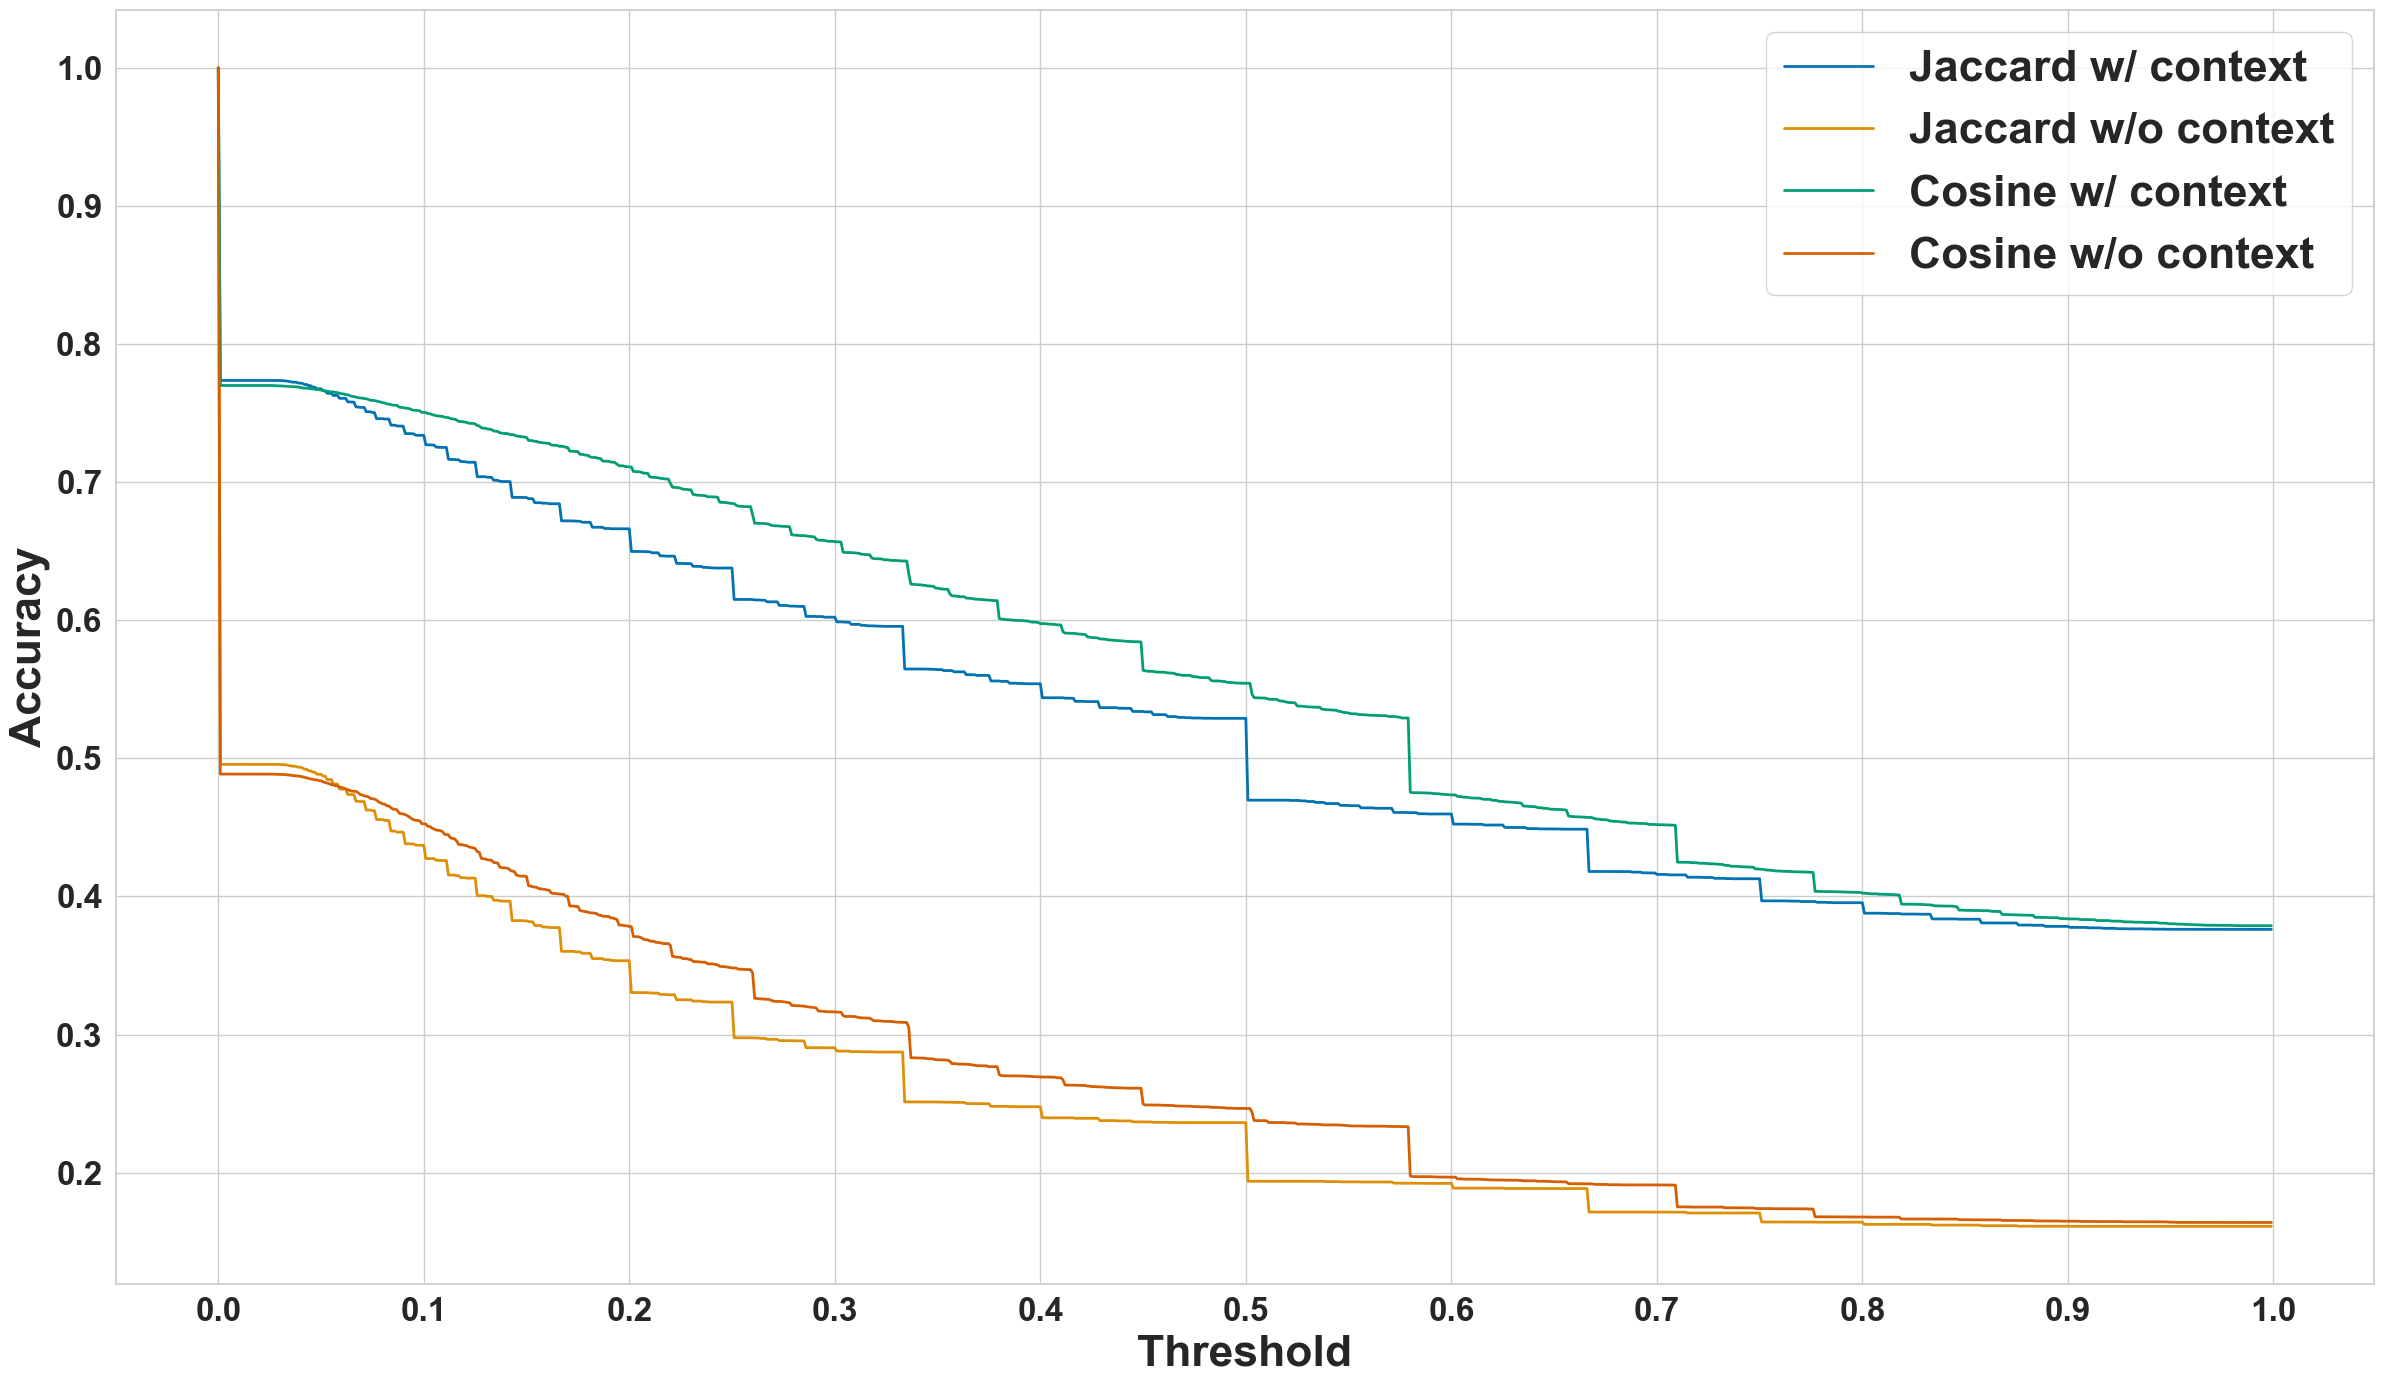

In [16]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("colorblind", as_cmap=False)
colors = [palette[i] for i in range(len(palette))]

fig, ax = plt.subplots(figsize=(24, 14))
sns.lineplot(x='Threshold', y='Jaccard Accuracy', data=df_metrics_with_context, label='Jaccard w/ context', color=colors[0], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Jaccard Accuracy', data=df_metrics_without_context, label='Jaccard w/o context', color=colors[1], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Cosine Accuracy', data=df_metrics_with_context, label='Cosine w/ context', color=colors[2], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Cosine Accuracy', data=df_metrics_without_context, label='Cosine w/o context', color=colors[3], lw=2, ax=ax)

legend_fontsize = 32
axis_label_fontsize = 32
tick_label_fontsize = 24

ax.legend(prop={'size': legend_fontsize, 'weight': 'bold'})
ax.set_xlabel('Threshold', fontsize=axis_label_fontsize, weight='bold')
ax.set_ylabel('Accuracy', fontsize=axis_label_fontsize, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
for label in ax.get_xticklabels():
    label.set_weight('bold')
for label in ax.get_yticklabels():
    label.set_weight('bold')
plt.tight_layout()
plt.savefig('accuracy_comparison_2.png', dpi=300)
plt.show()

C:\Users\nikol\AppData\Local\Temp\ipykernel_32256\3958741357.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=['Jaccard w/', 'Cosine w/', 'Jaccard w/o', 'Cosine w/o'],
C:\Users\nikol\AppData\Local\Temp\ipykernel_32256\3958741357.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  barplot = sns.barplot(x=['Jaccard w/', 'Cosine w/', 'Jaccard w/o', 'Cosine w/o'],


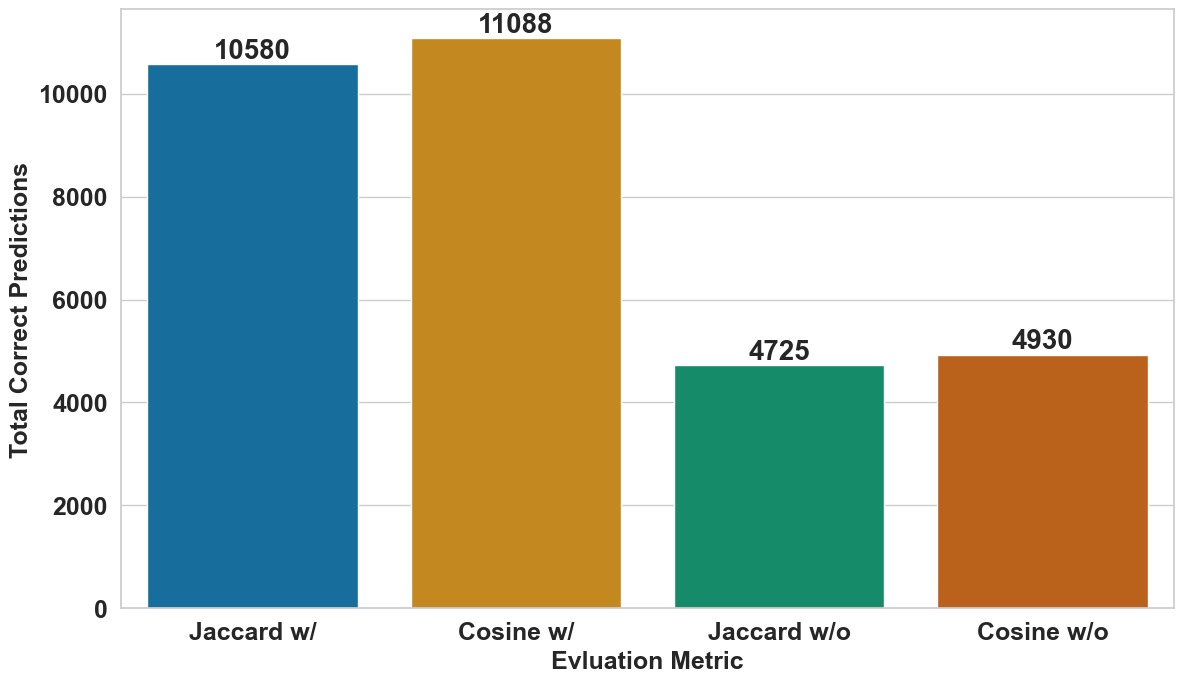

In [29]:
specific_threshold = 0.5

specific_df_with_context = df_metrics_with_context[df_metrics_with_context['Threshold'] == specific_threshold]
specific_df_without_context = df_metrics_without_context[df_metrics_without_context['Threshold'] == specific_threshold]

fig, ax = plt.subplots(figsize=(12, 7))

barplot = sns.barplot(x=['Jaccard w/', 'Cosine w/', 'Jaccard w/o', 'Cosine w/o'],
            y=[
                specific_df_with_context['Total Correct Jaccard'].values[0], 
                specific_df_with_context['Total Correct Cosine'].values[0],
                specific_df_without_context['Total Correct Jaccard'].values[0], 
                specific_df_without_context['Total Correct Cosine'].values[0]
            ],
            palette=palette)

axis_label_fontsize_2 = 18
bar_label_fontsize = 20 

ax.set_ylabel('Total Correct Predictions', fontsize=axis_label_fontsize_2, weight='bold')
ax.set_xlabel('Evluation Metric', fontsize=axis_label_fontsize_2, weight='bold')

for label in ax.get_xticklabels():
    label.set_weight('bold')
    label.set_size(axis_label_fontsize_2)  
for label in ax.get_yticklabels():
    label.set_weight('bold')
    label.set_size(axis_label_fontsize_2) 

for bar in barplot.patches:
    ax.text(bar.get_x() + bar.get_width() / 2., 
            bar.get_height(), 
            f'{int(bar.get_height())}', 
            ha='center', va='bottom', 
            fontsize=bar_label_fontsize, weight='bold')

plt.tight_layout()
plt.savefig('correct_predictions_at_threshold.png', dpi=300)
plt.show()